In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/rain_outliers_removed.csv")

# encoding RainTomorrow and RainToday as binary values
df.RainToday.replace(("Yes", "No"), (1,0), inplace = True)
df.RainTomorrow.replace(("Yes", "No"), (1,0), inplace = True)

# columns to be changed to one-hot encoding
categorical_columns = ["Season", "WindGustDir", "WindDir9am", "WindDir3pm"]

# creating one-hot encoding
df = pd.get_dummies(df, columns = categorical_columns)

df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,...,123710.00000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000
mean,12.419597,23.495168,0.199961,5.019636,7.473673,39.990664,14.680834,18.833732,67.856301,50.802320,...,0.05521,0.058645,0.070795,0.072387,0.067933,0.059041,0.066341,0.072589,0.063908,0.067771
std,6.363182,7.143505,0.445323,3.174230,3.903183,11.970577,7.612168,7.914690,18.695856,20.988174,...,0.22839,0.234960,0.256482,0.259129,0.251632,0.235703,0.248878,0.259462,0.244589,0.251354
min,-6.100000,2.400000,0.000000,0.000000,0.000000,7.000000,2.000000,2.000000,17.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.800000,18.100000,0.000000,2.400000,4.500000,31.000000,9.000000,13.000000,56.000000,36.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.200000,23.000000,0.000000,4.400000,8.300000,39.000000,13.000000,19.000000,69.000000,51.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.100000,28.600000,0.200000,7.000000,10.700000,48.000000,20.000000,24.000000,82.000000,65.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,31.000000,44.300000,2.000000,14.700000,14.500000,72.000000,35.000000,39.000000,100.000000,100.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
y = df.RainTomorrow.to_numpy()
X = df.drop(columns=['RainTomorrow']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train, X_test, y_train, y_test = StratifiedKFold(n_splits=2)

In [4]:
# from collections import Counter
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# count = Counter(y_train)
# print(count)

## So far tested: 
### if you're testing some method, please add it here
- If not specified, default values of classifiers used
### Basic split (20%)
- SVC:
    - StandardScaler: accuracy: 85%, balanced accuracy: 72%;
- KNN:
    - StandardScaler: accuracy: 80%, balanced accuracy: 64%;
- MLP Classifier:
    - StandardScaler: accuracy: 83%, balanced accuracy: 72%;
- Decision Tree Classifier:
    - StandardScaler: accuracy: 78%, balanced accuracy: 69%;
- Random Forest Classifier:
    - StandardScaler: accuracy: 85%, balanced accuracy: 72%; // 100 estimators
    - StandardScaler: accuracy: 85%, balanced accuracy: 72%; // 300 estimators
- AdaBoost Classifier:
    - StandardScaler: accuracy: 84%, balanced accuracy: 71%; // 100 estimators
    - StandardScaler: accuracy: 84%, balanced accuracy: 72%; // 300 estimators
- Gausian NB:
    - StandardScaler: accuracy: 72%, balanced accuracy: 70%;
- QuadraticDiscriminantAnalysis:
    - StandardScaler: accuracy: 68%, balanced accuracy: 69%;
- XGBoost Classifier:
    - StandardScaler: accuracy: 85%, balanced accuracy: 74%;
### Feature selection:
- K best (=20):
    - XGBoost Classifier:
        - StandardScaler: accuracy: 85%, balanced accuracy: 73%;



In [5]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k = 20)) ,
        ('classifier', MLPClassifier())
    ], 
    verbose=True
    ) 
    # here you can just substitute i.e SVC() with any classifier from sklearn you'd like and it will work, same thing refers to Scaler

In [6]:
%%time
pipe.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.2s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.1s
/home/witold/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[16:34:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   6.4s
CPU times: user 1min 6s, sys: 379 ms, total: 1min 6s
Wall time: 6.78 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=20)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))],
         verbose=Tr

In [7]:
y_predicted = pipe.predict(X_test)
metrics.balanced_accuracy_score(y_test, y_predicted)

0.736485501207045

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     19284
           1       0.73      0.53      0.61      5458

    accuracy                           0.85     24742
   macro avg       0.80      0.74      0.76     24742
weighted avg       0.84      0.85      0.84     24742

Accuracy of the model is: 85.23563171934363 %


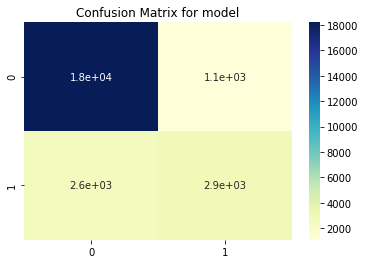

In [8]:
report = metrics.classification_report(y_test, y_predicted)
print(report)
print("Accuracy of the model is:",metrics.accuracy_score(y_test,y_predicted)*100,"%")
cm = metrics.confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,cmap="YlGnBu")
plt.title("Confusion Matrix for model")
plt.show()

In [9]:
# pipe.score(X_test, y_test)

In [10]:
# metrics.f1_score(y_test, y_predicted)